# Ejemplo Series de Tiempo

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#Tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras
# 


## La Serie

Vamos a trabajar con la serie de tiempo AirPassenger. Los datos describen la cantidad total de pasajeros de una aerolínea por mes entre los años 1949 a 1960. Se presentan las primeras 6 filas del conjunto de datos:

In [6]:
tf.random.set_seed(123)
airPas = pd.read_csv('../data/AirPassengers.csv',parse_dates=['Month'],index_col='Month')
print ('\n Parsed Data:')
print(airPas.head())


 Parsed Data:
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


A continuación podemos ver el gráfico de la serie. 

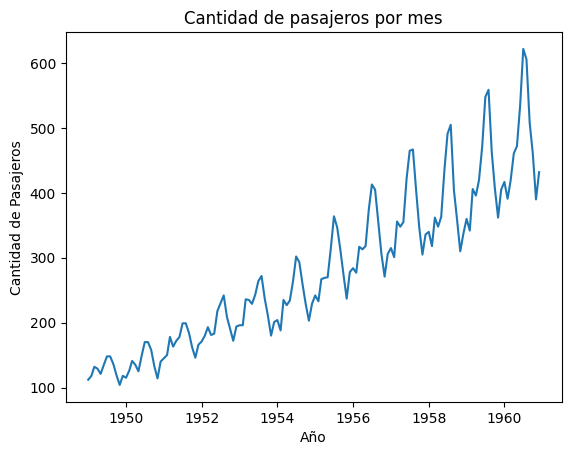

In [7]:
plt.plot(airPas)
plt.gca().set(title="Cantidad de pasajeros por mes", xlabel="Año", ylabel="Cantidad de Pasajeros")
plt.show()

Como se puede ver la serie no es estacionaria en media y la LSTM funciona mejor con series estacionarizadas así que vamos a diferenciarla na vez a ver si es suficiente para estacionarizarla en media

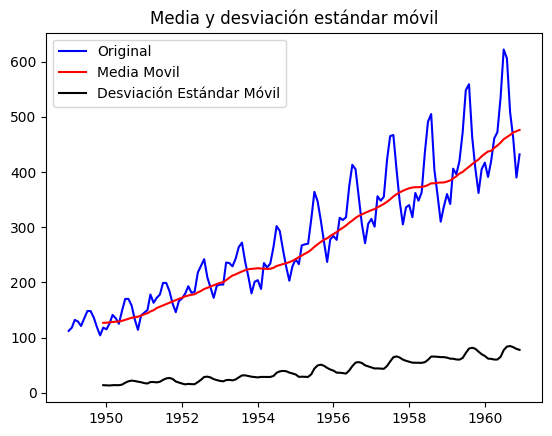

In [8]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = airPas.rolling(window=12).mean()
deMovil = airPas.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(airPas, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

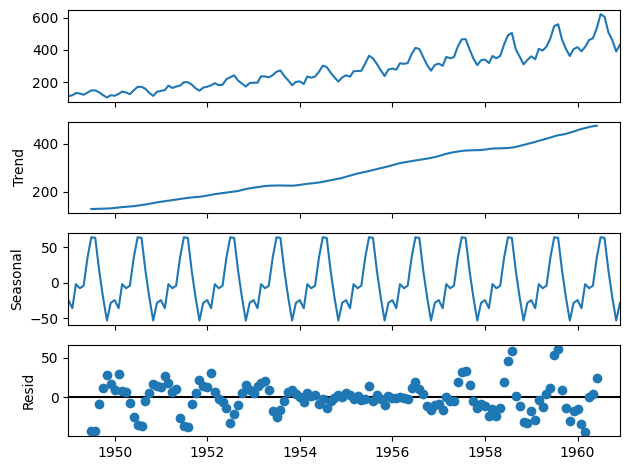

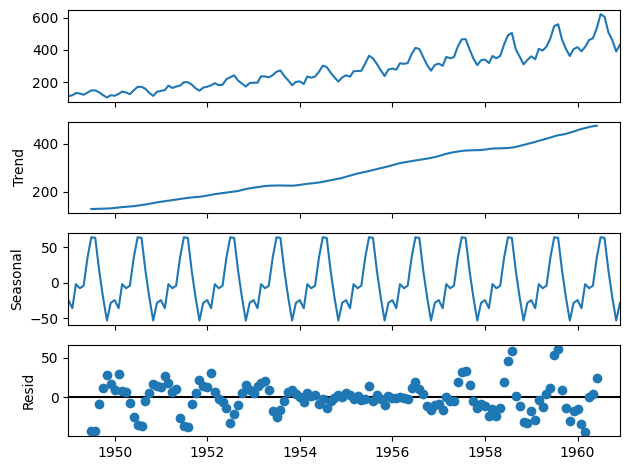

In [9]:
descomposicion = seasonal_decompose(airPas)
descomposicion.plot()

En este gráfico se puede observar que hay tendencia por lo que la serie no parece ser estacionaria en media y tampoco en varianza.

In [10]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(airPas, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.815369
p-value                        0.991880
# de retardos usados          13.000000
# de observaciones usadas    130.000000
Critical Value (1%)           -3.481682
Critical Value (5%)           -2.884042
Critical Value (10%)          -2.578770
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [11]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = airPas.diff()
ts_air_pas_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -2.889186
p-value                        0.046620
# de retardos usados          12.000000
# de observaciones usadas    131.000000
Critical Value (1%)           -3.481282
Critical Value (5%)           -2.883868
Critical Value (10%)          -2.578677
dtype: float64


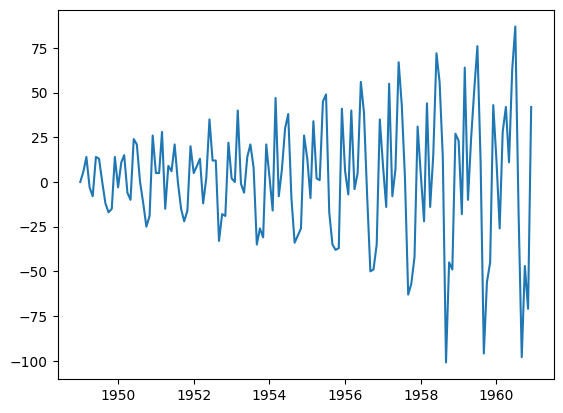

In [12]:
plt.plot(ts_air_pas_diff)

Las redes neuronales trabajan mejor con los datos normalizados así que vamos a normalizar la serie:

In [13]:
scaler = StandardScaler()
ts_air_pas_scaled = scaler.fit_transform(ts_air_pas_diff) 
ts_air_pas_scaled[1:7]


array([[ 0.11270364],
       [ 0.35137017],
       [-0.15579621],
       [-0.30496279],
       [ 0.35137017],
       [ 0.32153685]])

Vamos a separar la serie en entrenamiento, validación y prueba. En este caso, tendremos 60% para entrenamiento y 20% para validación y prueba respectivamente.

In [14]:
val_prueba = round(0.2*len(ts_air_pas_scaled))
val_prueba

29

In [15]:
entrenamiento = round(0.6*len(ts_air_pas_scaled))
val_prueba = round(0.2*len(ts_air_pas_scaled))
test = ts_air_pas_scaled[(entrenamiento+val_prueba)-1:]
validation = ts_air_pas_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = ts_air_pas_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

30

Para que pueda usarse el argoritmo LSTM es necesario transformar la serie en una supervisada, de manera que las observaciones anteriores sean capaces de estimar la siguiente. En este caso vamos a usar el mes anterior para predecir el siguiente por lo que vamos a transformar el arreglo de numpy en una matriz de dos dimensiones en la que la dimensión 1 sea el instante t-1 y la dimensión 2 sea el instante t

In [16]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)



In [17]:
print(train[0:6])
print(x_train[0:6])
print(y_train[0:6])


[[ 0.        ]
 [-0.06629626]
 [ 0.11270364]
 [ 0.35137017]
 [-0.15579621]
 [-0.30496279]]
[[ 0.        ]
 [-0.06629626]
 [ 0.11270364]
 [ 0.35137017]
 [-0.15579621]
 [-0.30496279]]
[-0.06629626  0.11270364  0.35137017 -0.15579621 -0.30496279  0.35137017]



## Creando el modelo
Para que pueda hacerse el modelo se le tiene que suministrar una matriz de 3 dimensiones siendo estas:
- ***Muestras:*** número de observaciones en cada lote, también conocido como tamaño del lote.
- ***Pasos de tiempo:*** Pasos de tiempo separados para una observación dada. En este ejemplo los pasos de tiempo = 1
- ***Características:*** Para un caso univariante, como en este ejemplo, las características = 1  

Un modelo LSTM permite ingresar datos a una red y hacer predicciones basados en pasos individuales de datos secuenciales. Como es una serie de tiempo donde queremos predecir el próximo elemento, usaremos un modelo secuencial, para predecir el próximo elemento, por esto es que el paso es 1.

El número de neuronas en la capa de salida (Dense) debe estar en la forma en que necesitamos la salida, en el caso de las series de tiempo necesitamos una neurona porque queremos predecir un valor. 

Vamos a convertir los conjuntos en matrices de 3 dimensiones:

In [18]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

29

In [19]:
x_train

array([[[ 0.        ]],

       [[-0.06629626]],

       [[ 0.11270364]],

       [[ 0.35137017]],

       [[-0.15579621]],

       [[-0.30496279]],

       [[ 0.35137017]],

       [[ 0.32153685]],

       [[-0.06629626]],

       [[-0.42429605]],

       [[-0.57346263]],

       [[-0.513796  ]],

       [[ 0.35137017]],

       [[-0.15579621]],

       [[ 0.26187022]],

       [[ 0.38120348]],

       [[-0.24529616]],

       [[-0.36462942]],

       [[ 0.64970333]],

       [[ 0.56020338]],

       [[-0.06629626]],

       [[-0.42429605]],

       [[-0.81212916]],

       [[-0.63312927]],

       [[ 0.70936996]],

       [[ 0.08287032]],

       [[ 0.08287032]],

       [[ 0.7690366 ]],

       [[-0.513796  ]],

       [[ 0.20220359]],

       [[ 0.11270364]],

       [[ 0.56020338]],

       [[-0.06629626]],

       [[-0.513796  ]],

       [[-0.72262921]],

       [[-0.54362932]],

       [[ 0.53037007]],

       [[ 0.08287032]],

       [[ 0.20220359]],

       [[ 0.32153685]],



### Creamos el modelo.   
#### Tensor Flow
Vamos a utilizar solo una capa LSTM 

In [20]:
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((paso,caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()

#Tensor Flow 2
#modelo1 = Sequential()
#modelo1.add(LSTM(lote,batch_input_shape=(lote,paso,caracteristicas),stateful=True))
#modelo1.add(Dense(1))
#modelo1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

Compilamos el modelo. Las métricas que nos van a servir para saber como funciona el modelo en términos de la pérdida es el error medio cuadrado. 
Se le puso una detención temprana para ahorrar tiempo de entrenamiento. Para el entrenamiento del modelo cuando se da cuenta de que no habrá disminución de la pérdida en las siguientes épocas.

In [37]:
#early_stop = EarlyStopping(monitor='val_loss', patience=1)
modelo1.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.1), metrics = [RootMeanSquaredError()])

Vamos a entrenar el modelo. Para eso configuramos las épocas que es la cantidad de iteraciones. Lo pondremos en 50.

In [39]:
epocas = 150
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2158 - root_mean_squared_error: 0.4538 - val_loss: 1.1277 - val_root_mean_squared_error: 1.0619
Epoch 2/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2157 - root_mean_squared_error: 0.4537 - val_loss: 1.1286 - val_root_mean_squared_error: 1.0623
Epoch 3/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2156 - root_mean_squared_error: 0.4536 - val_loss: 1.1294 - val_root_mean_squared_error: 1.0627
Epoch 4/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2155 - root_mean_squared_error: 0.4535 - val_loss: 1.1301 - val_root_mean_squared_error: 1.0631
Epoch 5/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2155 - root_mean_squared_error: 0.4535 - val_loss: 1.1307 - val_root_mean_squared_error: 1.0634
Epoch 6/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2155 - root_mean_squared_error: 0.4535 - val_loss: 1.1313 - val_root_mean_squared_error: 1.0636
Epoch 7/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss:

Como vemos la pérdida empieza a disminuir bastante bien hasta la época 40 que parece estancarse. Hay bastante diferencia entre el modelo de entrenamiento y el de validación.  Siempre se puede tunear el parámetro de la tasa de aprendizaje, y combinarlo con el early stopping, sobre todo con modelos más complejos.

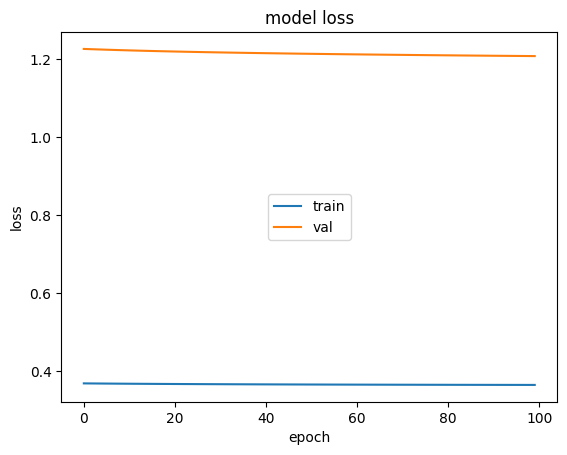

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

<Axes: >

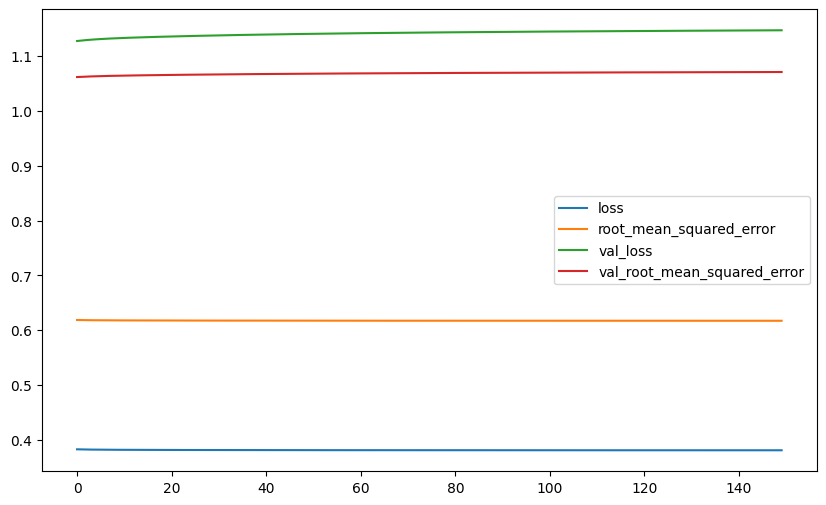

In [44]:
losses_df1 = pd.DataFrame(history.history)

losses_df1.plot(figsize = (10,6))

Evaluemos ahora el modelo según la pérdida en cada uno de los conjuntos de datos.

In [40]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3082 - root_mean_squared_error: 0.5505  
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.1472 - root_mean_squared_error: 1.0711
Pérdida en Prueba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 2.3086 - root_mean_squared_error: 1.5194


[2.3085575103759766, 1.519393801689148]

Ahora vamos a predecir con el modelo 1.  

In [41]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = airPas.values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = airPas.values , n=entrenamiento+val_prueba)


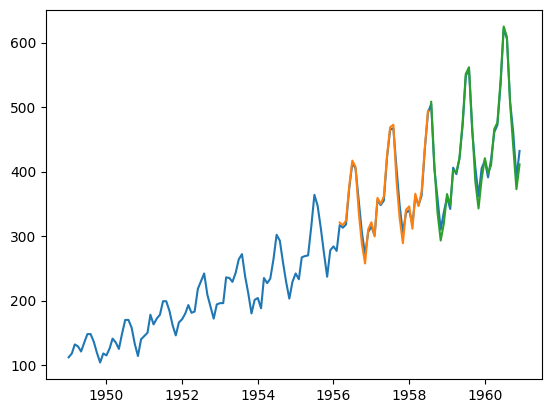

In [88]:
df_val = pd.DataFrame(prediccion_val,index=airPas[(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test,index=airPas[entrenamiento+len(df_val):len(airPas)].index)


plt.plot(airPas)
plt.plot(df_val)
plt.plot(df_test)



Para modelos muy complejos y que llevan mucho tiempo de entrenamiento es posible guardarlos y cargarlos, para poderlos reutilizar sin tener que re entrenarlos.

In [47]:
# guardar el modelo
save_model(modelo1, "Modelos/lstm1_serie_tiempo.keras")

# cargar el modelo
modelo1 = load_model("Modelos/lstm1_serie_tiempo.keras")

C:\Users\lgarc\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### PyTorch

### Referencias
- https://github.com/Vineet214/TimeSeriesForecasting-LSTM.git
- https://medium.com/@vineet.pandya/use-tensorflow-lstm-for-time-series-forecasting-770ec789d2ce